### Classifying Movie-Genres based on their Information.
techniques used:

- API requests
- Naive Bayes Classification 

In [ ]:
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd 
import tmdbsimple as tmdb
#import json
import swifter 

### Steps 
We want to classify, wheter or not a movie belongs to the Drama-Genre, given some *trigger-words* in the Overview.
Say for example, the word "tragedy" is in the Overview. Is it more likely to be a Drama Movie or not? 

1. clean the Text (i.e. remove Stop words, etc.) 
2. Calculate prior probs $$\frac{n_{Drama}}{total}$$ and $$\frac{n_{non-Drama}}{total}$$ 
3. create 2 word Histogramms: One for Dramamovies and one for non-Dramamovies
4. Calculate their relative frequencies within both groups 
5. Calculate Bayes, where the triggerword is in the denominator  $$P(Drama | Tragedy) = \frac{P(Tragedy | Drama) \cdot P(Drama)}{P(Tragedy)}$$
<br>
$$P(non-Drama| Tragedy) = \frac{P(Tragedy | non-Drama) \cdot P(non-Drama)}{P(Tragedy)}$$

### Sourced from Kaggle: 
https://www.kaggle.com/datasets/darshanpatel3112/top-rated-movies-from-tmdb 

In [2]:
movies = pd.read_csv("Data\movies.csv") 
movies = movies.drop("Unnamed: 0", axis = 1)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              10000 non-null  int64  
 1   original_title  10000 non-null  object 
 2   overview        9997 non-null   object 
 3   popularity      10000 non-null  float64
 4   vote_average    10000 non-null  float64
 5   vote_count      10000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 468.9+ KB


In [67]:
movies.vote_count = movies.vote_count.astype("int32")
movies.id = movies.id.astype("int32")

Gathering the Genres of the movie from the TMDB API:
<br>
very timeconsuming, the Dataframe was hence saved: 

Now the Genres from each film have been gathered. Some movies have up to 9 Genres. Thus 9 new Columns are created.

In [3]:
Genres = pd.read_csv("Data\Genres.csv") 
Genres.head()

,Genre,Genre2,Genre3,Genre4,Genre5,Genre6,Genre7,Genre8,Genre9
0,Drama,Crime,None,None,None,None,None,None,None
1,Drama,Crime,None,None,None,None,None,None,None
2,Comedy,Fantasy,None,None,None,None,None,None,None
3,Drama,Crime,None,None,None,None,None,None,None
4,Drama,History,War,None,None,None,None,None,None


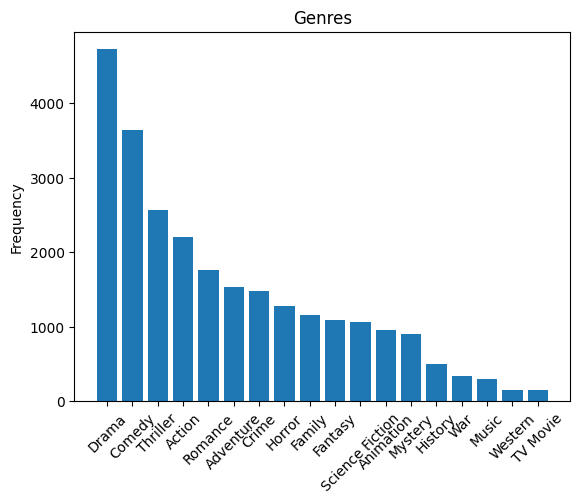

In [4]:
unique_genres = pd.Series(Genres.values.flatten()).value_counts()
unique_genres = unique_genres.iloc[1:] 

plt.xticks(rotation=45)
plt.bar(unique_genres.index, unique_genres)
plt.ylabel('Frequency')
plt.title('Genres')
plt.show()
# Note: one Movie can have multiple Genres, so the sum of the Barplot != 10_000

In [88]:
#Generate a dummy of Movies, that can be classified as Drama 
drama_loc = lambda row: 1 if ("Drama" in list(row)) else 0 
drama = Genres.swifter.apply(drama_loc, axis = 1)

Pandas Apply:   0%|          | 0/10000 [00:00<?, ?it/s]

In [89]:
prob_drama = sum(drama)/10_000
prob_non_drama = 1 - prob_drama
prob_drama
# Almost equal groups 

0.4723

For multiple word, we calculate each Posterior Prob for every word (i.e. in a sentence) and multiply their probs
<br>
(independece assumtion gives the name _naive_ Bayes, although we do expect words to have a certain order and connections with each other.) 

In [41]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zogaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zogaj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

- from: movies.overview[0]

'Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch, Vito Corleone barely survives an attempt on his life, his youngest son, Michael steps in to take care of the would-be killers, launching a campaign of bloody revenge.'

In [129]:
def trim(text):
    if isinstance(text, str) :
        text = text.lower()
        words = text.split()
        words = [word for word in words if word not in stopwords.words('english')]
        text_without_stopwords = ' '.join(words)

        return text_without_stopwords
    return ""

In [7]:
overview2 = pd.read_csv('Data\overview2.csv')

In [12]:
df = pd.concat([drama, overview2], axis = 1)
df = df.rename(columns={0: 'drama'})
drama_groups = df.groupby("drama")
nondrama_df, drama_df = (drama_groups.get_group(drama) for drama in drama_groups.groups)
display(drama_df.head(), nondrama_df.head())

,drama,overview
0,1,"spanning years 1945 1955, chronicle fictional ..."
1,1,"framed 1940s double murder wife lover, upstand..."
3,1,"continuing saga corleone crime family, young v..."
4,1,true story businessman oskar schindler saved t...
5,1,"raj rich, carefree, happy-go-lucky second gene..."


,drama,overview
2,0,70-year-old malena gets second chance life mag...
6,0,"young girl, chihiro, becomes trapped strange n..."
12,0,"unlikely friendship boy, mole, fox horse trave..."
13,0,"burger-loving hit man, philosophical partner, ..."
14,0,"civil war rages union confederacy, three men –..."


From here we need to clean the "overview" columns of both DataFrames. 
<br> 
1. Flatten the columns
2. Join into one list
3. Remove puntuation 

In [26]:
words_drama = re.sub(r'[^\w\s]', '', ' '.join(drama_df.overview.values.flatten()))

#Note there are 3 NaN values that need to be cleaned (i.e. converted to string)
cleaned_nondrama = [str(t) if isinstance(t, float) else t for t in nondrama_df.overview.values.flatten()]
words_nondrama = re.sub(r'[^\w\s]', '', ' '.join(cleaned_nondrama))

In [50]:
words1 = word_tokenize(words_drama)
word_freq_drama = nltk.FreqDist(words1)

words2 = word_tokenize(words_nondrama)
word_freq_non_drama = nltk.FreqDist(words2)

###### Pick some words that are associated with dramas, nonDramas and count their occurence in the overview 

In [69]:
sad = ["death", "pain", "dramatic", "grief"]
happy = ["happy", "love", "fun", "friends"]

print("Sad: ", "\n",sad)
print("Drama: ",[word_freq_drama[s] for s in sad])
print("nonDrama: ",[word_freq_non_drama[s] for s in sad], "\n")

print("Happy: ","\n",happy)
print("Drama: ",[word_freq_drama[s] for s in happy])
print("nonDrama: ",[word_freq_non_drama[s] for s in happy])

Sad:  
 ['death', 'pain', 'dramatic', 'grief']
Drama:  [205, 18, 14, 14]
nonDrama:  [176, 12, 3, 1] 

Happy:  
 ['happy', 'love', 'fun', 'friends']
Drama:  [34, 519, 13, 253]
nonDrama:  [38, 306, 42, 410]


#### now convert the frequencies into probabilities

In [84]:
total_count = sum(word_freq_non_drama.values())
prob_words_non_drama = {item: count/total_count for item, count in word_freq_non_drama.items()}

total_count2 = sum(word_freq_drama.values())
prob_words_drama = {item: count/total_count2 for item, count in word_freq_drama.items()}

In [119]:
setd = set(prob_words_drama.keys())
setnd = set(prob_words_non_drama.keys())

delta = setd.difference(setnd)
list(delta)[0:10] #...

['raciallycharged',
 'ponzi',
 'drummy',
 'clutter',
 'sidesaddle',
 'togetherand',
 'rimbaud',
 'sunday',
 'abel',
 'traced']

##### Some Words are only in one Dictionary, but not in the other. 
<br>
For zero occurences: Either add $\alpha$ counts to each histogramm bin, or drop them completly

In [136]:
def NBC(prompt):
    pd = [math.log(prob_drama)]
    pnd = [math.log(prob_non_drama)]
    
    clean_prompt = re.sub(r'[^\w\s]', '', trim(prompt)).split()
    for word in clean_prompt:
        try: 
            x = prob_words_drama[word]
            pd.append(math.log(x))
        except KeyError:
            pd.append(0)
            
        try: 
            y = prob_words_non_drama[word]
            pnd.append(math.log(y))
            
        except KeyError:
            pnd.append(0)
            
    if sum(pd) > sum(pnd):
        print("The movie is more likely a drama")
    else:
        print("The movie is more likely not a drama")
    print("Drama: ", sum(pd),"\n","nonDrama: ", sum(pnd))

In [142]:
test = "after many futile attempts i tried to resign and gave up"
NBC(test)

The movie is more likely a drama
Drama:  -47.59106291593444 
 nonDrama:  -60.656739643382636
